### Importing the Functions


In [1]:
# Misc
from IPython import get_ipython
from IPython.display import display
import hashlib
import os
from pprint import pprint
from time import monotonic
import ipywidgets as widgets
import sys
from tabulate import tabulate
from rich import print
from rich.console import Console
from rich.table import Table

# Data Wrangling
import pandas as pd
import numpy as numpy

# Data Manipulation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx

src_path = os.path.abspath(os.path.join(os.getcwd(), "../../../src"))
sys.path.append(src_path)
from helpers import currency


# Machine Learning 
from sklearn.ensemble import RandomForestClassifier
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv, GATConv

# Result Metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss, matthews_corrcoef, balanced_accuracy_score




In [2]:
class GNN_base(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN_base, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)  # Activation
        x = self.conv2(x, edge_index)
        return F.softmax(x, dim=1) 

# Define the Enhanced GNN Model
class GNN_arch1(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=4):
        super(GNN_arch1, self).__init__()

        # Initial Graph Convolutional Layer (GCN)
        self.gcn1 = GCNConv(input_dim, hidden_dim)

        # Graph Attention Layer (GAT)
        self.gat1 = GATConv(hidden_dim, hidden_dim, heads=heads, concat=False)

        # Fully Connected Layer for Node Classification
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, output_dim)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index):
        # Apply GCN
        x = self.gcn1(x, edge_index)
        x = F.relu(x)

        # Apply GAT for attention-based feature learning
        x = self.gat1(x, edge_index)
        x = F.relu(x)

        # Fully connected layers for **node-level classification**
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)  

In [3]:
class CellTimer:
    def __init__(self):
        self.start_time = None

    def start(self, *args, **kwargs):
        self.start_time = monotonic()

    def stop(self, *args, **kwargs):
        try:
            delta = round(monotonic() - self.start_time, 2)
            print(f"\n⏱️ Execution time: {delta}s")
        except TypeError:
            # The `stop` will be called when the cell that
            # defines `CellTimer` is executed, but `start`
            # was never called, leading to a `TypeError` in
            # the subtraction. Skip it
            pass


timer = CellTimer()
ipython = get_ipython()
ipython.events.register("pre_run_cell", timer.start)
ipython.events.register("post_run_cell", timer.stop)

### Pipeline for the process

In [ ]:
class model_pipeline:

    def __init__(self, df_path, random_state_):

        self.df_path = df_path
        self.df = pd.read_csv(self.df_path)
        self.random_state_ = random_state_

        self.X = None
        self.y = None

        self.X_train = None
        self.y_train = None

        self.X_test = None
        self.y_test = None

        self.X_val = None
        self.y_val = None

        self.y_pred = None
        self.y_proba = None

        self.model = None

    def df_summary(self):
        print('DATA HEAD')
        display(self.df.head())
        print('FEATURE TYPE')
        display(self.df.info())

    def y_statistics(self):
        print('Normalised Value Count: ')
        print(self.df['Is Laundering'].value_counts(normalize=True))

    # Feature Transformation

    def currency_normalization(self):
        usd_conversion = currency.get_usd_conversion(self.df_path)
        self.df['Amount Paid (USD)'] = self.df.apply(lambda row: row['Amount Paid'] * usd_conversion.get(row['Payment Currency'], 1), axis=1)
        self.df['Amount Received (USD)'] = self.df.apply(lambda row: row['Amount Received'] * usd_conversion.get(row['Receiving Currency'], 1), axis=1)

    def date_to_unix(self):
        self.df['Timestamp'] = pd.to_datetime(self.df['Timestamp']).astype(int) / 10**9 

    def label_encoding(self, features_to_encode):
        for col in features_to_encode:
            self.df[col] = LabelEncoder().fit_transform(self.df[col])

    def neighbor_context(self):
        G = nx.DiGraph()

        for _, row in self.df.iterrows():
            G.add_edge(row['Account'], row['Account.1'], weight=row['Amount Paid (USD)'])

        self.df['degree_centrality'] = self.df['Account'].map(nx.degree_centrality(G))
        self.df['pagerank'] = self.df['Account'].map(nx.pagerank(G))

    def generate_tensor(self,edge_features):
        self.train_node_features = torch.tensor(self.X_train[edge_features].values, dtype=torch.float)
        labels = torch.tensor(self.y_train.values, dtype=torch.long)
        edge_index = torch.tensor(self.X_train[["Account", "Account.1"]].values.T, dtype=torch.long)
        self.train_data = Data(x=self.train_node_features, edge_index=edge_index, y=labels)

        self.test_node_features = torch.tensor(self.X_test[edge_features].values, dtype=torch.float)
        labels = torch.tensor(self.y_test.values, dtype=torch.long)
        edge_index = torch.tensor(self.X_test[["Account", "Account.1"]].values.T, dtype=torch.long)
        self.test_data = Data(x=self.test_node_features, edge_index=edge_index, y=labels)
    
    def split_x_y(self, X_cols, y_col):
        self.X = self.df[X_cols]
        self.y = self.df[y_col]

    def split_train_test(self, test_size_):
        # Random Split For now
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=test_size_, random_state=self.random_state_, stratify=self.y)
    
    def random_forest_classifier(self, param):      
        self.model = RandomForestClassifier(**param)
        self.model.fit(self.X_train, self.y_train)

    def training_gnn_model(self, learning_rate, epoch_,gnn_model):
            
        self.model = globals()[gnn_model](input_dim=self.train_node_features.shape[1], hidden_dim=16, output_dim=2)
        # Define optimizer and loss function
        optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(device)
        self.train_data = self.train_data.to(device)

        # Training loop
        epochs = epoch_
        for epoch in range(epochs):
            self.model.train()
            optimizer.zero_grad()
            out = self.model(self.train_data.x, self.train_data.edge_index)
            loss = criterion(out, self.train_data.y)
            loss.backward()
            optimizer.step()
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch} - Loss: {loss.item():.4f}")

    def predict_model_gnn(self):
        self.model.eval()
        with torch.no_grad():
            out_probs = self.model(self.test_data.x, self.test_data.edge_index)
            self.y_proba = out_probs.cpu().numpy()
            self.y_pred = out_probs.argmax(dim=1).cpu().numpy()

    def predict_model(self):
        self.y_pred = self.model.predict(self.X_test)
        self.y_proba = self.model.predict_proba(self.X_test)

    import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, auc, log_loss, matthews_corrcoef, balanced_accuracy_score
)

def result_metrics(self, model_type="traditional"):
   
    print("\n[Model Performance Metrics]\n")
    
    print(classification_report(self.y_test, self.y_pred, digits=4))

    cm = confusion_matrix(self.y_test, self.y_pred)
    accuracy = balanced_accuracy_score(self.y_test, self.y_pred)
    mcc = matthews_corrcoef(self.y_test, self.y_pred)
    
    print(f"Balanced Accuracy: {accuracy:.4f}")
    print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

    logloss = None
    if self.y_proba is not None:
        try:
            logloss = log_loss(self.y_test, self.y_proba)
            print(f"Log Loss: {logloss:.4f}")
        except ValueError:
            print("⚠️ Log Loss calculation skipped (invalid probability values).")

    if self.y_proba is not None:
        if model_type == "gnn":
            self.y_proba = torch.softmax(torch.tensor(self.y_proba), dim=1).numpy()

        if len(self.y_proba.shape) == 1 or self.y_proba.shape[1] == 1:
            y_proba_positive = self.y_proba
        else:
            y_proba_positive = self.y_proba[:, 1]

        fpr, tpr, _ = roc_curve(self.y_test, y_proba_positive)
        roc_auc = roc_auc_score(self.y_test, y_proba_positive)
        precision, recall, _ = precision_recall_curve(self.y_test, y_proba_positive)
        pr_auc = auc(recall, precision)

        print(f"AUC-ROC Score: {roc_auc:.4f}")
        print(f"Precision-Recall AUC: {pr_auc:.4f}")

        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0])
        axes[0].set_title("Confusion Matrix")
        axes[0].set_xlabel("Predicted Label")
        axes[0].set_ylabel("True Label")

        axes[1].plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}')
        axes[1].plot([0, 1], [0, 1], linestyle="--", color="gray")  # Baseline
        axes[1].set_title("ROC Curve")
        axes[1].set_xlabel("False Positive Rate")
        axes[1].set_ylabel("True Positive Rate")
        axes[1].legend()

        axes[2].plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
        axes[2].set_title("Precision-Recall Curve")
        axes[2].set_xlabel("Recall")
        axes[2].set_ylabel("Precision")
        axes[2].legend()

        plt.tight_layout()
        plt.show()



⏱️ Execution time: 0.0s


### RF Without Contextuality

              precision    recall  f1-score   support

           0     0.9991    0.9999    0.9995   1014634
           1     0.6810    0.1382    0.2297      1035

    accuracy                         0.9991   1015669
   macro avg     0.8400    0.5690    0.6146   1015669
weighted avg     0.9988    0.9991    0.9987   1015669

Balanced Accuracy: 0.5690
Matthews Correlation Coefficient (MCC): 0.3065
Log Loss: 0.0236
AUC-ROC Score: 0.6893
Precision-Recall AUC: 0.1815


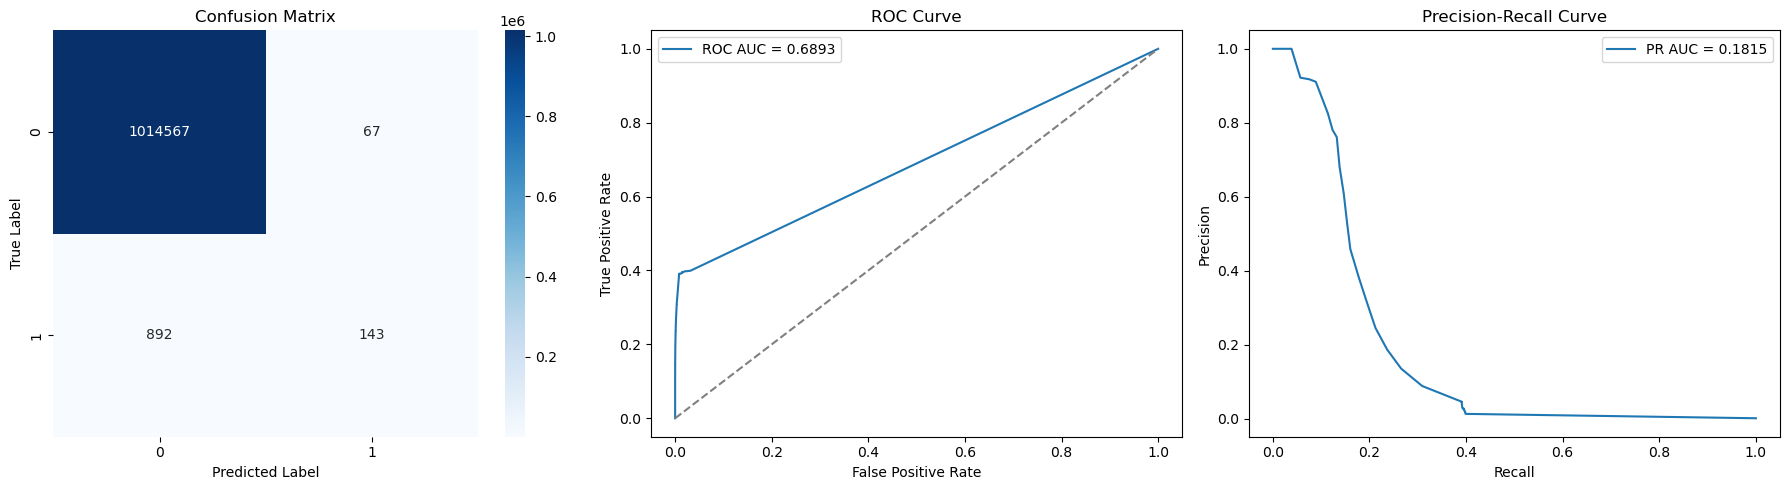


⏱️ Execution time: 240.14s


In [5]:
rf = model_pipeline(df_path='/Users/abhitay/Developer/Columbia_projects/CAP/dsi-capstone-spring-2025-TD-anti-money-laundering/Code/Abhitay/IBM/HI-Small_Trans.csv',random_state_=42)
rf.currency_normalization()
rf.date_to_unix()
rf.label_encoding(['Receiving Currency', 'Payment Currency', 'Payment Format','Account.1','Account'])

X_cols = ['Timestamp','Amount Paid (USD)','Amount Received (USD)','Payment Currency','Payment Format']
y_col = 'Is Laundering'
rf.split_x_y(X_cols=X_cols, y_col=y_col)
rf.split_train_test(test_size_=0.2)

rf.random_forest_classifier(param={'n_estimators': 20, 'random_state':42})
rf.predict_model()
rf.result_metrics()

### RF With Contextuality

              precision    recall  f1-score   support

           0     0.9991    1.0000    0.9996   1014634
           1     0.8470    0.1498    0.2545      1035

    accuracy                         0.9991   1015669
   macro avg     0.9231    0.5749    0.6270   1015669
weighted avg     0.9990    0.9991    0.9988   1015669

Balanced Accuracy: 0.5749
Matthews Correlation Coefficient (MCC): 0.3559
Log Loss: 0.0140
AUC-ROC Score: 0.8300
Precision-Recall AUC: 0.2418


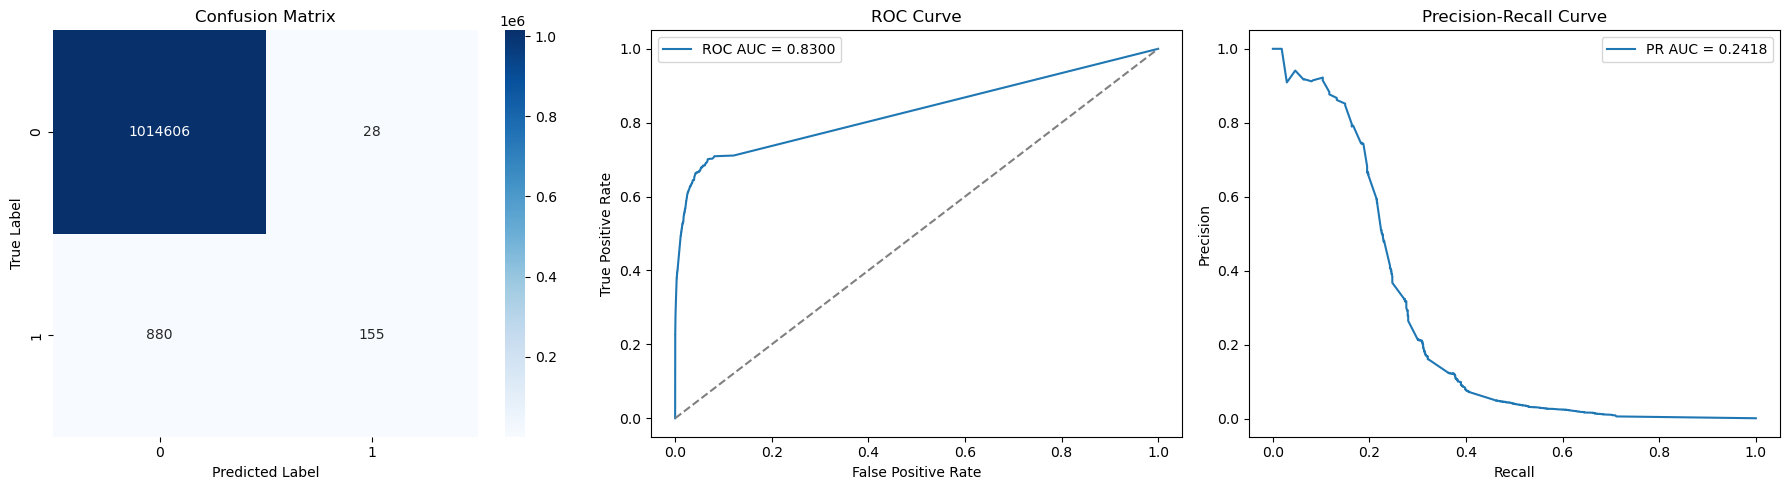


⏱️ Execution time: 281.41s


In [6]:
rfc = model_pipeline(df_path='/Users/abhitay/Developer/Columbia_projects/CAP/dsi-capstone-spring-2025-TD-anti-money-laundering/Code/Abhitay/IBM/HI-Small_Trans.csv',random_state_=42)
rfc.currency_normalization()
rfc.date_to_unix()
rfc.label_encoding(['Receiving Currency', 'Payment Currency', 'Payment Format','Account.1','Account'])
rfc.neighbor_context()

X_cols = ['Timestamp','Amount Paid (USD)','Amount Received (USD)','Payment Currency','Payment Format','degree_centrality','pagerank']
y_col = 'Is Laundering'
rfc.split_x_y(X_cols=X_cols, y_col=y_col)
rfc.split_train_test(test_size_=0.2)

rfc.random_forest_classifier(param={'n_estimators': 20, 'random_state':42})
rfc.predict_model()
rfc.result_metrics()

### Base GNN

Epoch 0 - Loss: 1.3023
Epoch 10 - Loss: 1.3023
Epoch 20 - Loss: 1.3023
Epoch 30 - Loss: 1.3023
Epoch 40 - Loss: 1.3023
Epoch 50 - Loss: 1.3023
Epoch 60 - Loss: 1.3023
Epoch 70 - Loss: 1.3023
Epoch 80 - Loss: 1.3023
Epoch 90 - Loss: 1.3023
              precision    recall  f1-score   support

           0     0.9989    0.0102    0.0203   1014634
           1     0.0010    0.9894    0.0020      1035

    accuracy                         0.0112   1015669
   macro avg     0.5000    0.4998    0.0112   1015669
weighted avg     0.9979    0.0112    0.0203   1015669

Balanced Accuracy: 0.4998
Matthews Correlation Coefficient (MCC): -0.0001
Log Loss: 15.7632
AUC-ROC Score: 0.4998
Precision-Recall AUC: 0.4952


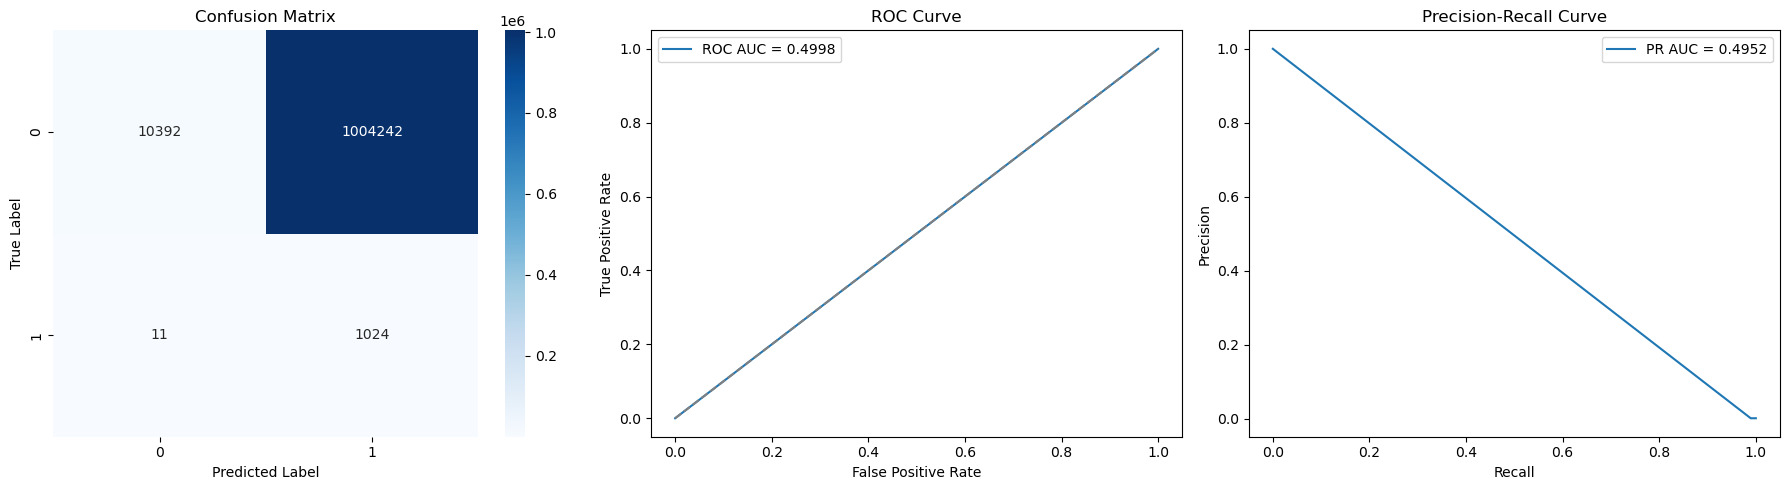


⏱️ Execution time: 292.09s


In [9]:
bgnn = model_pipeline(df_path='/Users/abhitay/Developer/Columbia_projects/CAP/dsi-capstone-spring-2025-TD-anti-money-laundering/Code/Abhitay/IBM/HI-Small_Trans.csv',random_state_=42)
bgnn.currency_normalization()
bgnn.date_to_unix()
bgnn.label_encoding(['Receiving Currency', 'Payment Currency', 'Payment Format','Account.1','Account'])
bgnn.neighbor_context()

X_cols = ['Timestamp','Amount Paid (USD)','Amount Received (USD)','Payment Currency','Payment Format','degree_centrality','pagerank','Account.1','Account']
y_col = 'Is Laundering'
bgnn.split_x_y(X_cols=X_cols, y_col=y_col)
bgnn.split_train_test(test_size_=0.2)

bgnn.generate_tensor(['Timestamp','Amount Paid (USD)','Amount Received (USD)','Payment Currency','Payment Format','degree_centrality','pagerank'])
bgnn.training_gnn_model(learning_rate=0.01,epoch_=100, gnn_model='GNN_base')
bgnn.predict_model_gnn()

bgnn.result_metrics()

### Architecture 1

Epoch 0 - Loss: 6485125.5000
Epoch 10 - Loss: 299170.0625
Epoch 20 - Loss: 341104.0000
Epoch 30 - Loss: 278662.8750
Epoch 40 - Loss: 106710.2344
Epoch 50 - Loss: 100254.6797
Epoch 60 - Loss: 61323.4727
Epoch 70 - Loss: 47839.3750
Epoch 80 - Loss: 28631.8711
Epoch 90 - Loss: 7.6746


/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.9990    1.0000    0.9995   1014634
           1     0.0000    0.0000    0.0000      1035

    accuracy                         0.9990   1015669
   macro avg     0.4995    0.5000    0.4997   1015669
weighted avg     0.9980    0.9990    0.9985   1015669



/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Balanced Accuracy: 0.5000
Matthews Correlation Coefficient (MCC): 0.0000
Log Loss: 0.6931
AUC-ROC Score: 0.5002
Precision-Recall AUC: 0.5005


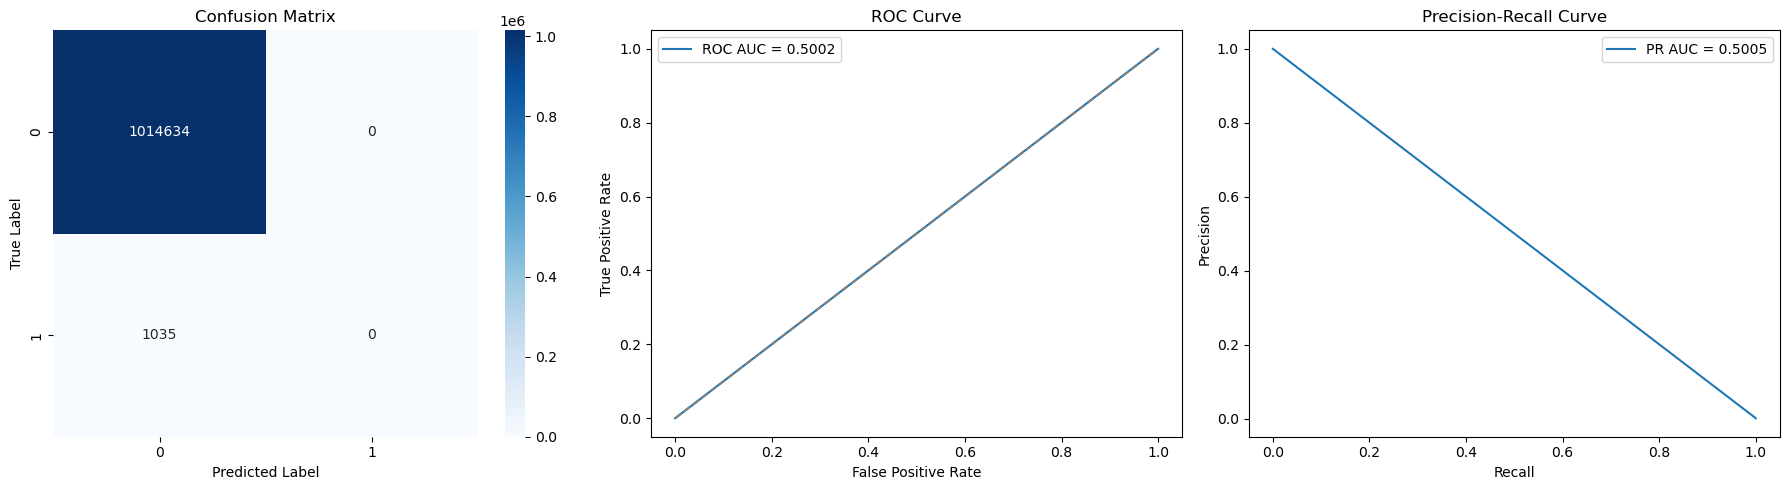


⏱️ Execution time: 1120.42s


In [10]:
a1gnn = model_pipeline(df_path='/Users/abhitay/Developer/Columbia_projects/CAP/dsi-capstone-spring-2025-TD-anti-money-laundering/Code/Abhitay/IBM/HI-Small_Trans.csv',random_state_=42)
a1gnn.currency_normalization()
a1gnn.date_to_unix()
a1gnn.label_encoding(['Receiving Currency', 'Payment Currency', 'Payment Format','Account.1','Account'])
a1gnn.neighbor_context()

X_cols = ['Timestamp','Amount Paid (USD)','Amount Received (USD)','Payment Currency','Payment Format','degree_centrality','pagerank','Account.1','Account']
y_col = 'Is Laundering'
a1gnn.split_x_y(X_cols=X_cols, y_col=y_col)
a1gnn.split_train_test(test_size_=0.2)

a1gnn.generate_tensor(['Timestamp','Amount Paid (USD)','Amount Received (USD)','Payment Currency','Payment Format','degree_centrality','pagerank'])
a1gnn.training_gnn_model(learning_rate=0.01,epoch_=100, gnn_model='GNN_arch1')
a1gnn.predict_model_gnn()

a1gnn.result_metrics()